In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster')
import random

In [2]:
from project_helper import *

## Models With and Without Outliers

### Import, Split, and Standardize Data

In [3]:
df = pd.DataFrame.from_csv('../data/merged/all_data_2006_to_2016.csv', index_col=None)

In [4]:
# split train/test by indices before removing outliers
# so that we can have a consistent split between tests

# seed for consistent splits
random.seed(1636)

# all idxs
idxs = list(range(len(df)))

# idxs of outliers
outlier_idxs = list((df.MSA_abbr == 'NEW_ORLEANS_LA').nonzero()[0])
outlier_idxs += list(((df.MSA_abbr == 'MEMPHIS_TN') & (df.year == 2016)).nonzero()[0])
outlier_idxs += list(((df.MSA_abbr == 'BATON_ROUGE_LA') & (df.year == 2007)).nonzero()[0])

# shuffle and split
random.shuffle(idxs)
split = int(len(idxs)*0.7)
train_all = idxs[:split]
test_all = idxs[split:]

# remove outliers
train_no = [idx for idx in train_all if idx not in outlier_idxs]
test_no = [idx for idx in test_all if idx not in outlier_idxs]

In [5]:
# drop MSA names
df = df.drop(['MSA_corr','MSA_orig','MSA_abbr'], axis=1)

In [6]:
# separate labels and features

label_col = 'murder_per_100_k'

# with outliers
x_train_all = df.iloc[train_all].drop([label_col], axis=1)
y_train_all = df.iloc[train_all][label_col]
x_test_all = df.iloc[test_all].drop([label_col], axis=1)
y_test_all = df.iloc[test_all][label_col]

# without outliers
x_train_no = df.iloc[train_no].drop([label_col], axis=1)
y_train_no = df.iloc[train_no][label_col]
x_test_no = df.iloc[test_no].drop([label_col], axis=1)
y_test_no = df.iloc[test_no][label_col]

print('All Sizes match: {}'.format(len(x_train_all)==len(y_train_all)))
print('Clean Sizes match: {}'.format(len(x_train_no)==len(y_train_no)))

All Sizes match: True
Clean Sizes match: True


In [7]:
# standardize data

from sklearn.preprocessing import StandardScaler

# with outliers
standardizer = StandardScaler().fit(x_train_all)
x_train_all = standardizer.transform(x_train_all)
x_test_all = standardizer.transform(x_test_all)

# no outliers
standardizer = StandardScaler().fit(x_train_no)
x_train_no = standardizer.transform(x_train_no)
x_test_no = standardizer.transform(x_test_no)

In [8]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, BayesianRidge, HuberRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR

In [9]:
# instantiate and fit models
def make_models(x_train, y_train):
    md = dict()

    md['linear'] = LinearRegression().fit(x_train, y_train)
    md['ridge'] = RidgeCV(cv=5).fit(x_train, y_train)
    md['huber'] = GridSearchCV(HuberRegressor(),{'epsilon': [1.0,1.2,1.4,1.6,1.8]}).fit(x_train, y_train).best_estimator_
    md['knn'] = GridSearchCV(KNeighborsRegressor(),{'n_neighbors':[5,10,20,40]}).fit(x_train, y_train).best_estimator_
    md['adaboost'] = GridSearchCV(AdaBoostRegressor(), {'learning_rate':[0.1,0.3,0.6,1.0]}).fit(x_train, y_train).best_estimator_
    md['svr'] = GridSearchCV(SVR(), {'C':[0.01,0.1,1,10,100],'epsilon':[0.001,0.01,0.1,1,10]}).fit(x_train, y_train)
    
    return md

### Fit Models

In [10]:
# with outliers
exp_1 = run_experiment(make_models, 10, x_train_all, y_train_all, x_test_all, y_test_all)

# without outliers
exp_2 = run_experiment(make_models, 10, x_train_no, y_train_no, x_test_no, y_test_no)

/Users/davidloving/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


### Accuracy Results

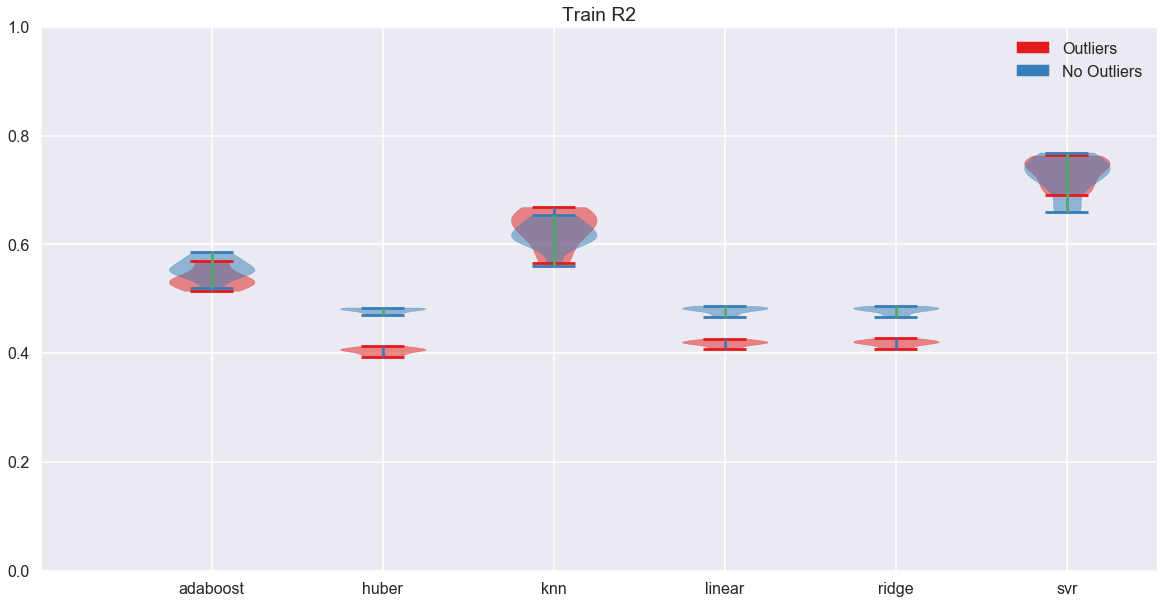

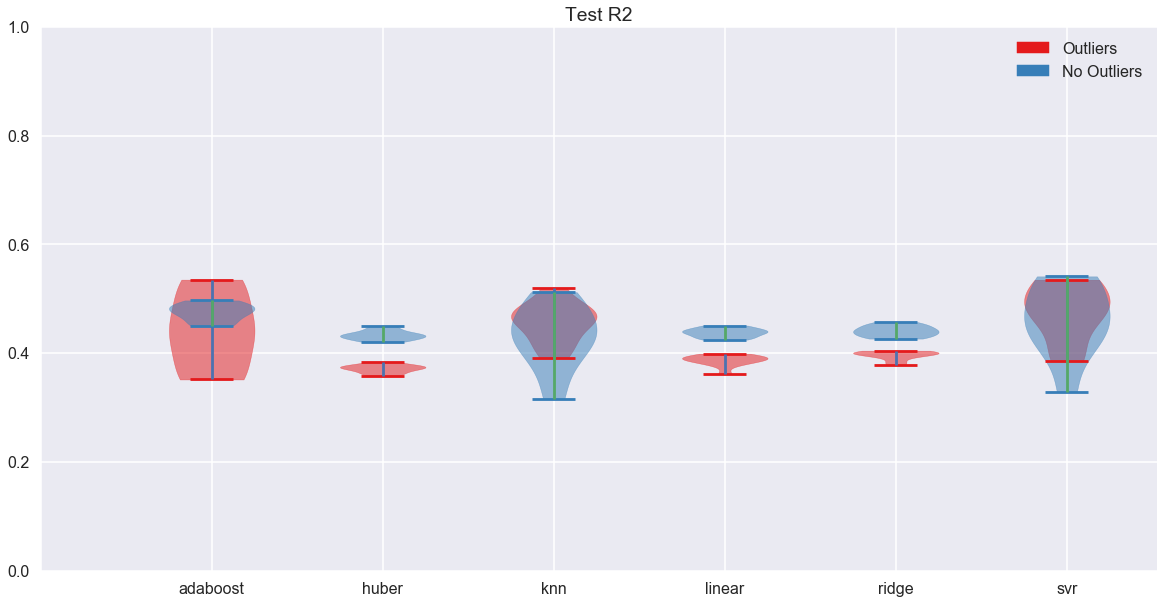

In [24]:
colors = plt.cm.Set1.colors

violin_plots([exp_1, exp_2],
             ['Train R2','Test R2'],
             experiment_name=['Outliers','No Outliers'],
             center_zero=False,
             cmap=colors)

### Outlier Effects on Confidence Intervals

In [27]:
# instantiate and fit models
def make_linear_models(x_train, y_train):
    md = dict()

    md['linear'] = LinearRegression().fit(x_train, y_train)
    md['ridge'] = RidgeCV(cv=15).fit(x_train, y_train)
    md['lasso'] = LassoCV(cv=15).fit(x_train, y_train)
    md['huber'] = GridSearchCV(HuberRegressor(),{'epsilon': [1.0,1.2,1.4,1.6,1.8]}).fit(x_train, y_train).best_estimator_
    
    return md

In [28]:
coeff_names = df.drop('murder_per_100_k',axis=1).columns

# with outliers
exp_3 = run_experiment(make_linear_models, 10, x_train_all, y_train_all, x_test_all, y_test_all, coeff_names)

# without outliers
exp_4 = run_experiment(make_linear_models, 10, x_train_no, y_train_no, x_test_no, y_test_no, coeff_names)

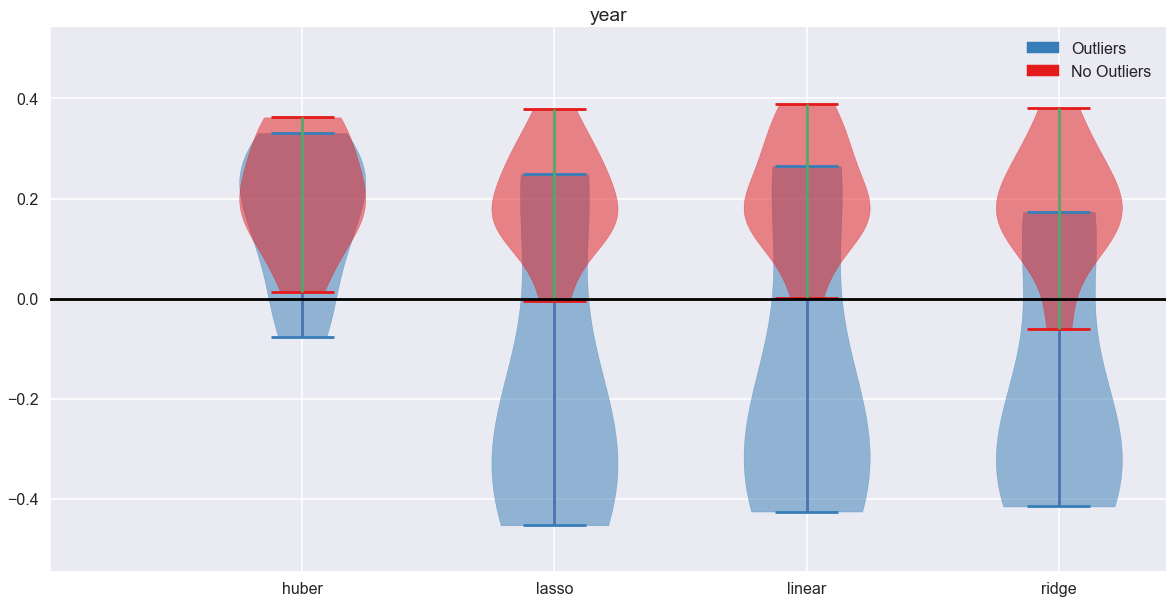

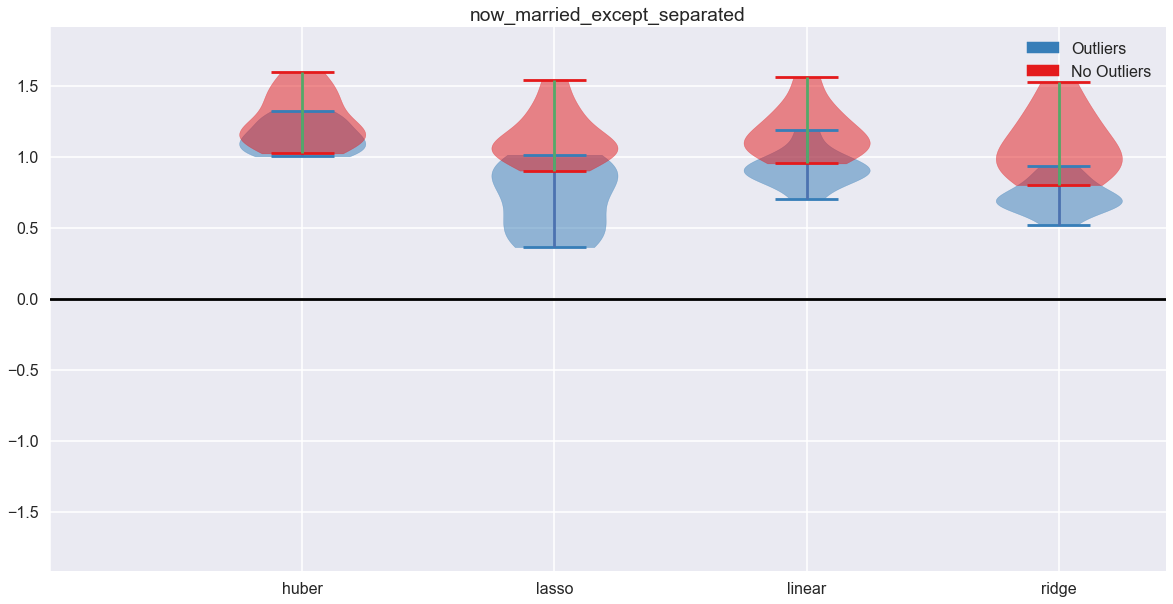

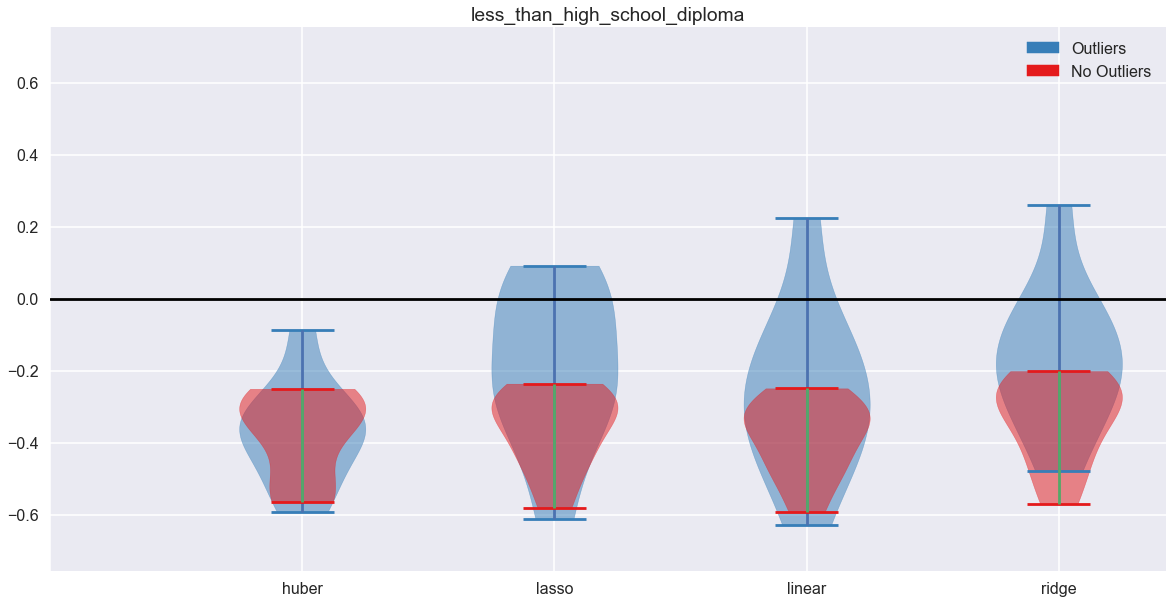

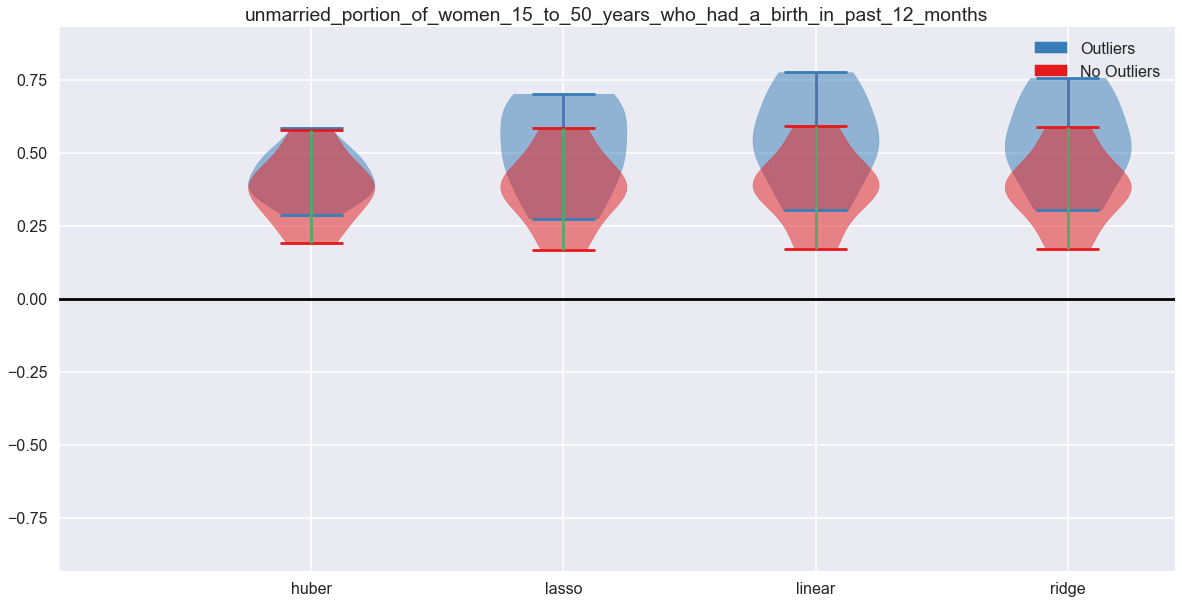

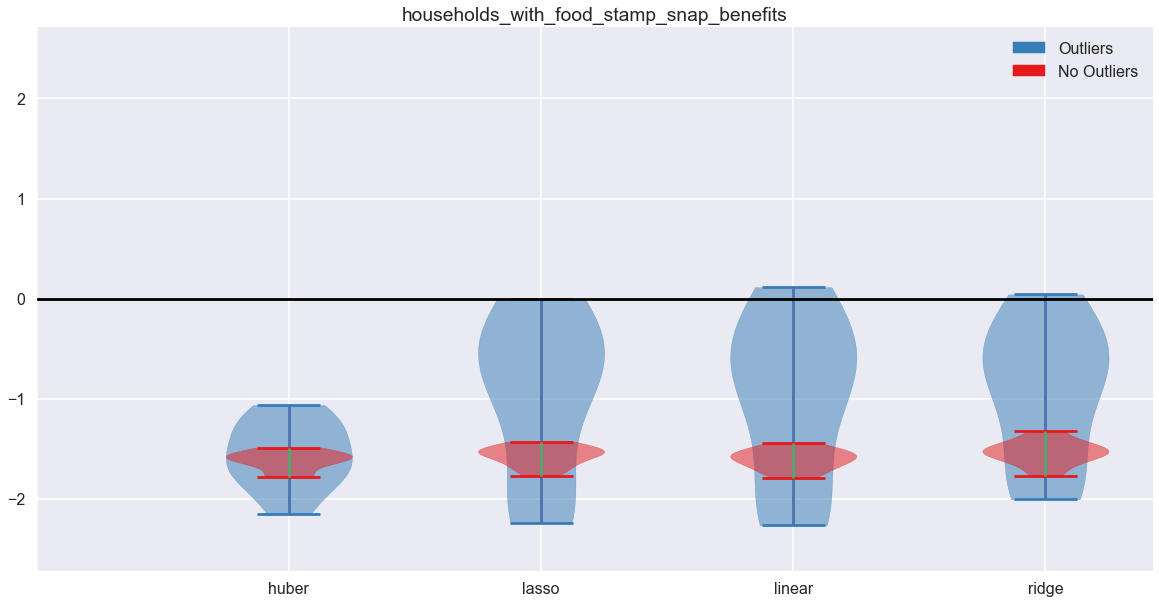

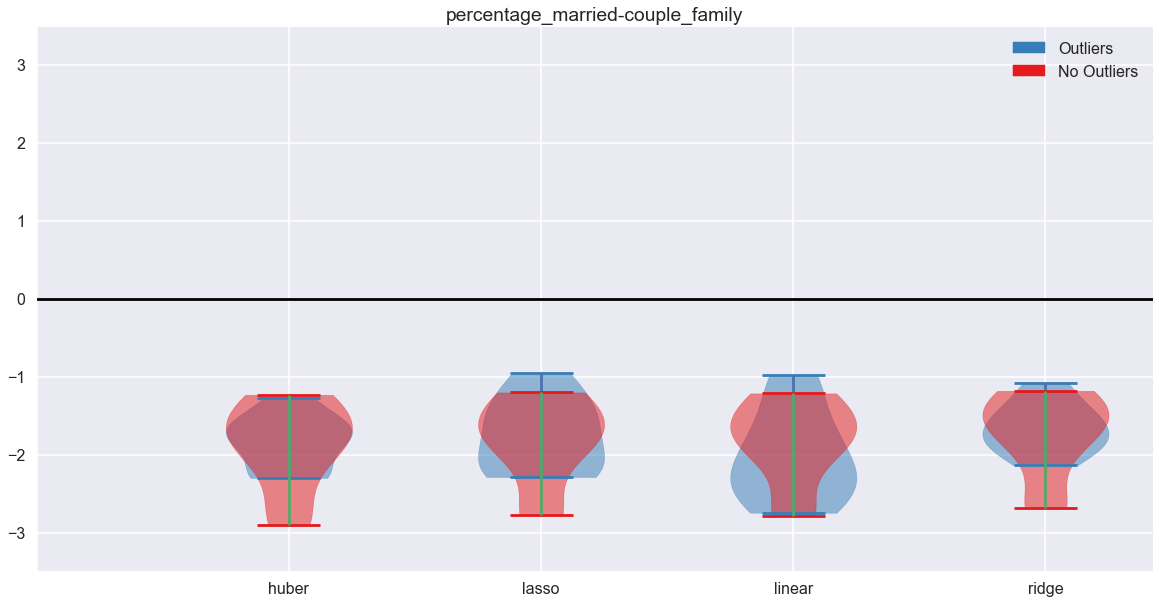

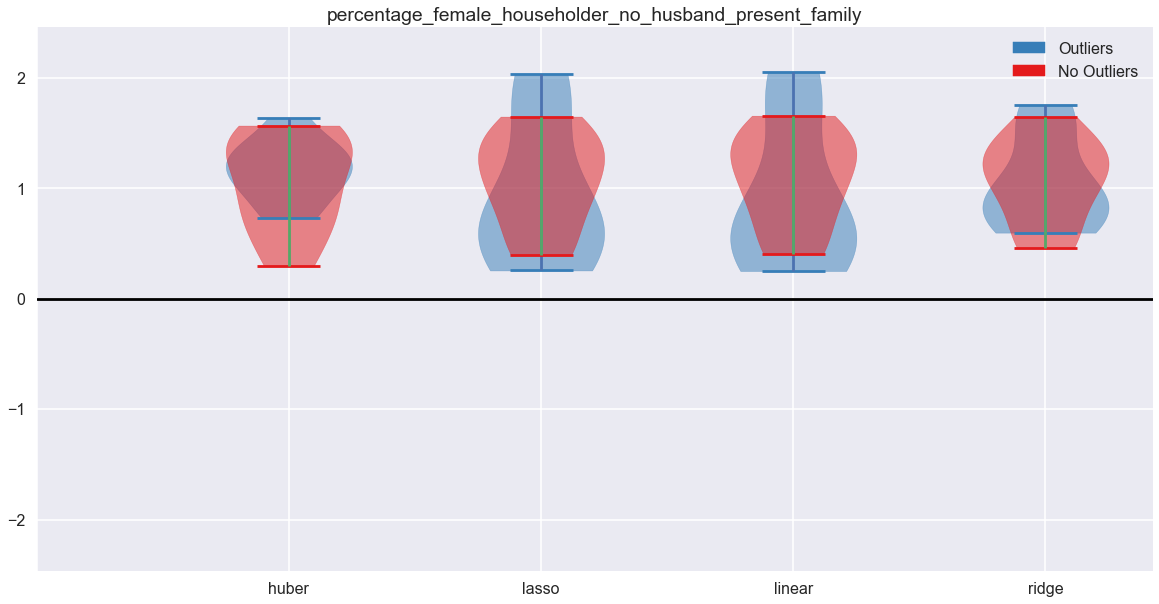

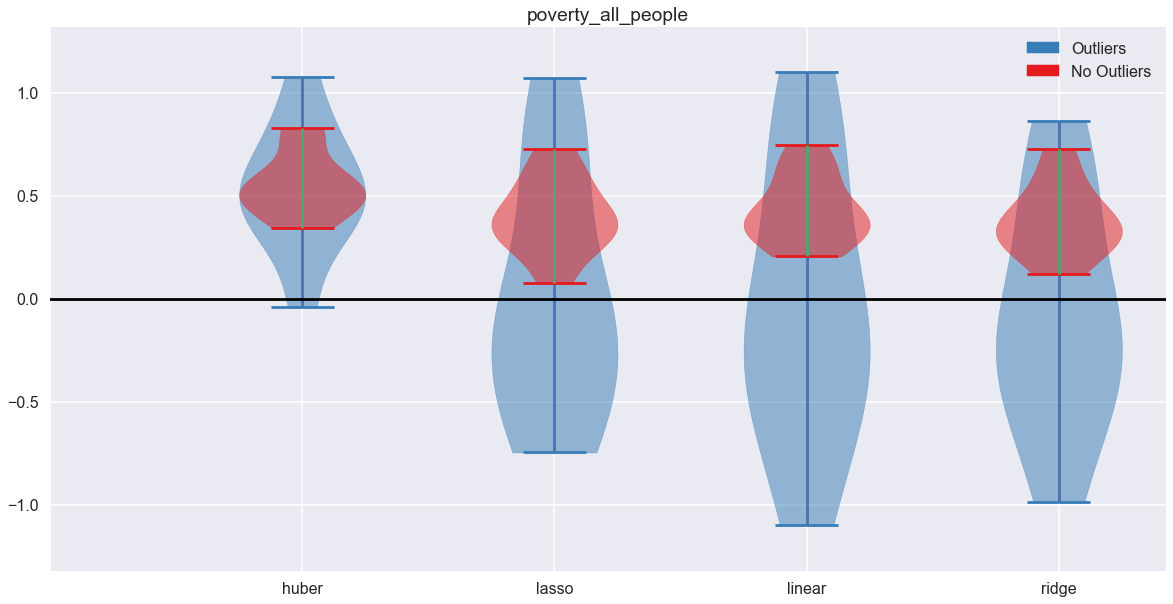

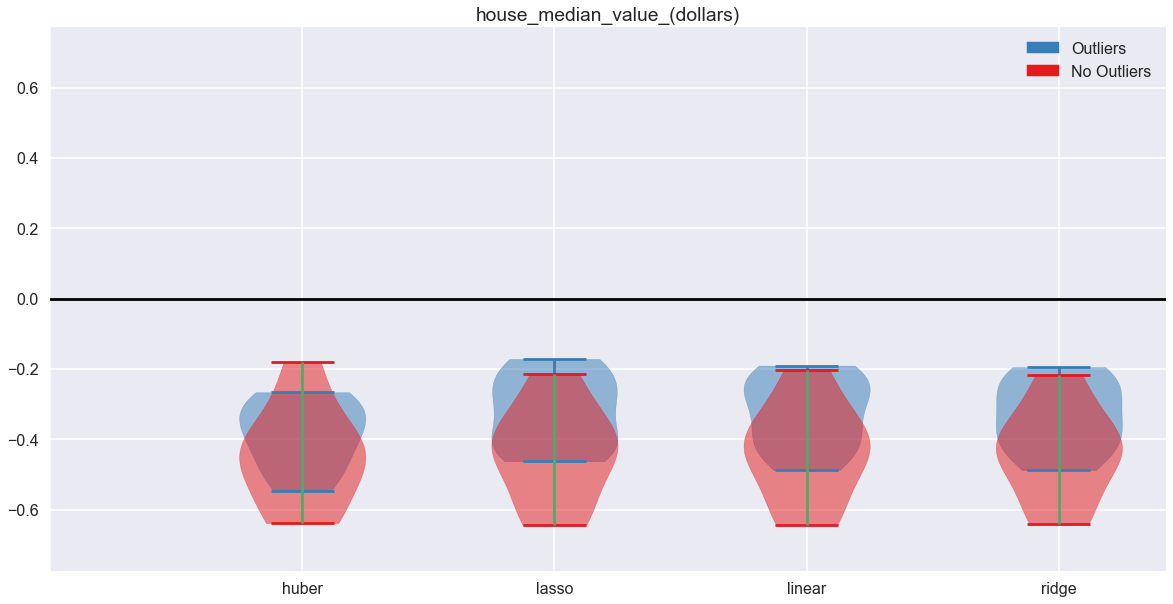

In [34]:
violin_plots([exp_3, exp_4], coeff_names, experiment_name=['Outliers','No Outliers'], cmap=colors[:2][::-1])